# Exploring generations

In [1]:
# improts
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob
import pickle
import shutil
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
import py3Dmol
import pandas as pd

# For highlight colors
from matplotlib.colors import ColorConverter

from ipywidgets import interact,fixed,IntSlider

from ase.db import connect
from ase.io import read
from ase.visualize import view


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:

    sys.path.append(module_path)
    
# Custom functions 
from my_utils.analysis import draw_generation,conf_viewer, sort_ga, natural_keys, atoi

#IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 500,500
IPythonConsole.drawOptions.addAtomIndices = True

font = {'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)


# The original structure as reference:  

In [2]:
Mo_hipt_path = '/home/magstr/Documents/nitrogenase/schrock/reference_structures/mo.xyz'
draw_generation(Mo_hipt_path)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## PATHS: 

In [76]:
# Initilized path variables0
templates = Path('../templates/')

# Path to folder with GA.pkl files
generation_path = Path('~').expanduser()/"generation_data/run"
# What GA to look at 
gen  = 'GA50.pkl'

# How many molecules in the pop to look at 
size = 100

# Name of folder to put xyz files in 
xyz_files = generation_path / 'xyz_files'
Path(xyz_files).mkdir(exist_ok=True)

In [77]:
with open(generation_path/gen, "rb") as f:
    gen = pickle.load(f)

In [78]:
final_gen_score=[]
for i,elem in enumerate(gen.survivors.molecules[0:size]):
    final_gen_score.append(elem.score)
    with open(xyz_files/f'xtbopt{i}.xyz', "w+") as f:
        if elem.structure:
            for line in elem.structure:                
                f.write(line)

In [79]:
def draw_gen(
    width=800,
    height=600,
    Hs=False,
    confId=-1,
    multipleConfs=False,
    atomlabel=False,
    hit_ats=None,
    inp=None
):
    try:
        p = py3Dmol.view(width=width, height=height)
        p.addModel(inp, "xyz")
        p.setStyle({"stick": {"radius": 0.2}, "sphere": {"radius": 0.3}})
        if atomlabel:
            p.addPropertyLabels("index")  # ,{'elem':'H'}

        p.zoomTo()
        p.update()
        p.show()
    except Exception as e:
        print(e)
        print("py3Dmol, RDKit, and IPython are required for this feature.")

In [80]:
# Extract stuff from the generation

mols = []
list_idx = []
cut_idx = []
score = []
pre_mols = []
pre_mol_idx = []

children_mols = []
children_idx = []
children_cut_idx = []
    
for elem in gen.survivors.molecules:
    mols.append(elem.rdkit_mol)    
    list_idx.append(elem.idx)
    score.append(round(elem.score,3))
    cut_idx.append([elem.cut_idx])
    pre_mols.append(elem.original_mol)
    
for elem in gen.children.molecules:
    children_mols.append(elem.rdkit_mol)    
    children_idx.append(elem.idx)
    children_cut_idx.append([elem.cut_idx])
    

lst = sorted(xyz_files.rglob('xtbopt*.xyz'))
lst = [str(x) for x in lst]
paths = sorted(lst, key = natural_keys)
print(len(paths))


pop = {}
keys = range(len(paths))
for i in keys:
    pop[i] = (list_idx[i],final_gen_score[i],paths[i])

50


In [81]:
img  = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=25,legends=[f'idx: {x}  |   Score:  {round(score,3)}' for x, score in zip(list_idx,score)], subImgSize=(400,200), highlightAtomLists=cut_idx,returnPNG=False)

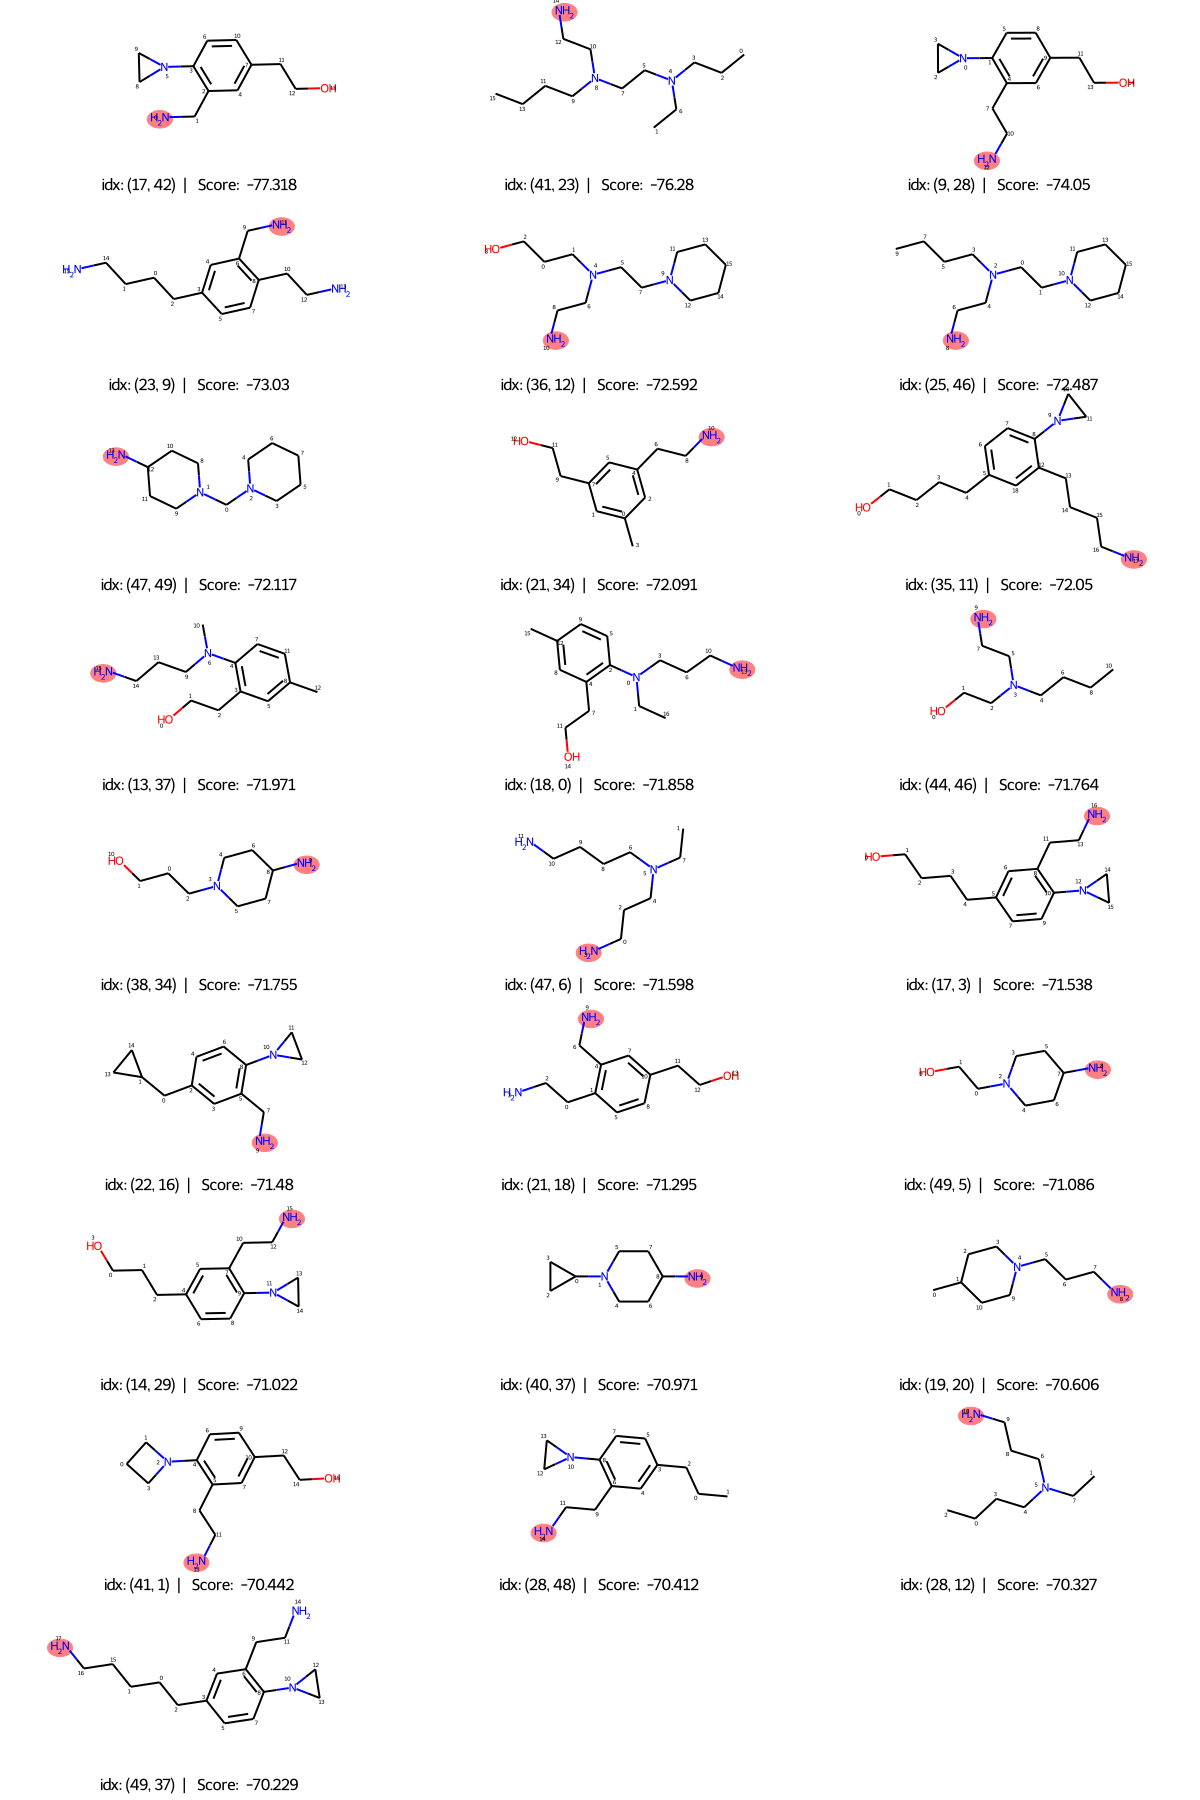

In [82]:
img

In [83]:
interact(conf_viewer,confs=fixed(pop),idx=IntSlider(min=0,max=len(paths)-1,step=1), width=fixed(1200), height=fixed(600));

interactive(children=(IntSlider(value=0, description='idx', max=49), Output()), _dom_classes=('widget-interact…

In [41]:
img  = Draw.MolsToGridImage(pre_mols,molsPerRow=3,maxMols=25,legends=[f'idx: {idx}' for idx in list_idx], subImgSize=(400,200),returnPNG=False)

In [42]:
#img

In [43]:
img  = Draw.MolsToGridImage(children_mols,molsPerRow=3,maxMols=9,legends=[f'idx: {idx}' for idx in children_idx], subImgSize=(400,200),returnPNG=False, highlightAtomLists=children_cut_idx)

/home/magstr/miniconda3/envs/mols_test/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:243: UserWarning: Truncating the list of molecules to be displayed to 9. Change the maxMols value to display more.
  % (maxMols))


In [44]:
#img

### Energy evolution through time

In [45]:
# Get gen paths
gen_objects = sorted(generation_path.rglob('GA*.pkl'), key=sort_ga)

In [46]:
avg_energy=[]
for elem in gen_objects:
    with open(elem, "rb") as f:
        #f.seek(0)
        gen = pickle.load(f)
        
        df = gen.gen2pd()['score']
        pop_size = len(df)
        
        # Remove the 9999 energies from mean calc
        df = df[df < 1000]
        
        avg_energy.append(df.mean())

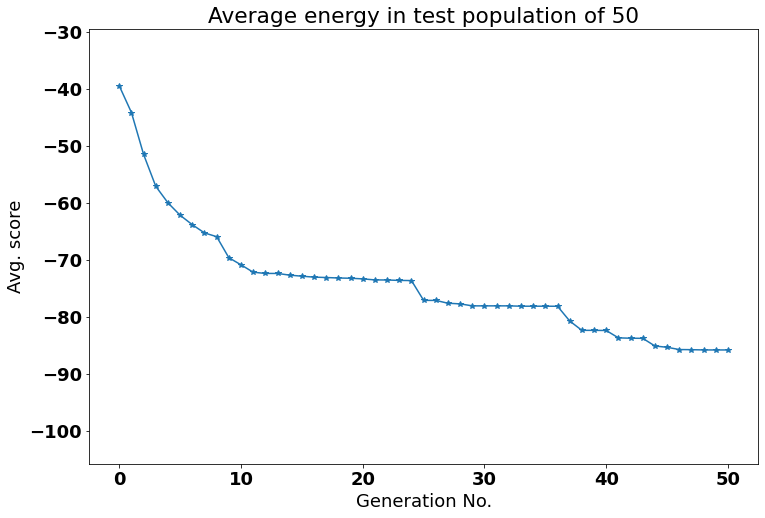

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(0,len(avg_energy))
ax.plot(x,avg_energy,'*-')
ax.set(xlabel='Generation No.', ylabel='Avg. score', title=f'Average energy in test population of {pop_size}', ylim =(min(avg_energy)-20,max(avg_energy)+10));
fig.savefig(generation_path/generation_path.stem, dpi=600)

# Compare two structures

In [24]:
# Path to folder with GA.pkl files
generation_path_longrun = Path('~').expanduser()/"generation_data/longrun"
# What GA to look at 
gen_longrun  = 'GA45.pkl'

# Path to folder with GA.pkl files
generation_path_long2 = Path('~').expanduser()/"generation_data/long2"
# What GA to look at 
gen_long2  = 'GA100.pkl'

In [25]:
with open(generation_path_longrun/gen_longrun, "rb") as f:
    gen_longrun = pickle.load(f)
    
with open(generation_path_long2/gen_long2, "rb") as f:
    gen_long2 = pickle.load(f)

In [26]:
path = Path('/home/magstr/generation_data/singlepoint_candidates/results')

In [27]:
candidates = []
for elem in gen_long2.survivors.molecules:
    if elem.idx in [(18,32),(32,70),(64,13)]:
        candidates.append(elem)
for elem in gen_longrun.survivors.molecules:
    if elem.idx in [(44,37),(27,41)]:
        candidates.append(elem)

In [28]:
# Create DFT dataframe
d = {'idx': [(18,32), (32,70), (64,13)],'XTB score': [-108.4, -163.52, -86.1], 'DFT': [34.76, 67.1, -36.0]}
df_long2 = pd.DataFrame(data=d)
df_long2

,idx,XTB score,DFT
0,"(18, 32)",-108.40,34.76
1,"(32, 70)",-163.52,67.10
2,"(64, 13)",-86.10,-36.00


In [29]:
# Create DFT dataframe
d = {'idx': [(44,37), (27,41)],'XTB score': [-77.2, -103.1], 'DFT': [-37.1, 11.6]}
df_longrun = pd.DataFrame(data=d)
df_longrun

,idx,XTB score,DFT
0,"(44, 37)",-77.2,-37.1
1,"(27, 41)",-103.1,11.6


In [30]:
df1 = gen_long2.gen2pd().loc[[(18,32),(32,70),(64,13)]]
df2= gen_longrun.gen2pd().loc[[(44,37),(27,41)]]
df_total = pd.concat([df1,df2])
df_total['DFT'] = [34.76, 67.1, -36.0,-37.1, 11.6]
df_total

,,score,energy,sa_score,rdkit_mol,DFT
generation,individual,,,,,
18,32,-108.375581,-108.375581,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7fbdfddf7870>,34.76
32,70,-163.518196,-167.439570,0.976580,<rdkit.Chem.rdchem.Mol object at 0x7fbdfddf7270>,67.10
64,13,-86.079413,-86.317547,0.997241,<rdkit.Chem.rdchem.Mol object at 0x7fbdfde28030>,-36.00
44,37,-79.229562,-79.229562,1.000000,<rdkit.Chem.rdchem.Mol object at 0x7fbdfdf81c30>,-37.10
27,41,-103.086978,-108.810688,0.947398,<rdkit.Chem.rdchem.Mol object at 0x7fbdffbcaa30>,11.60


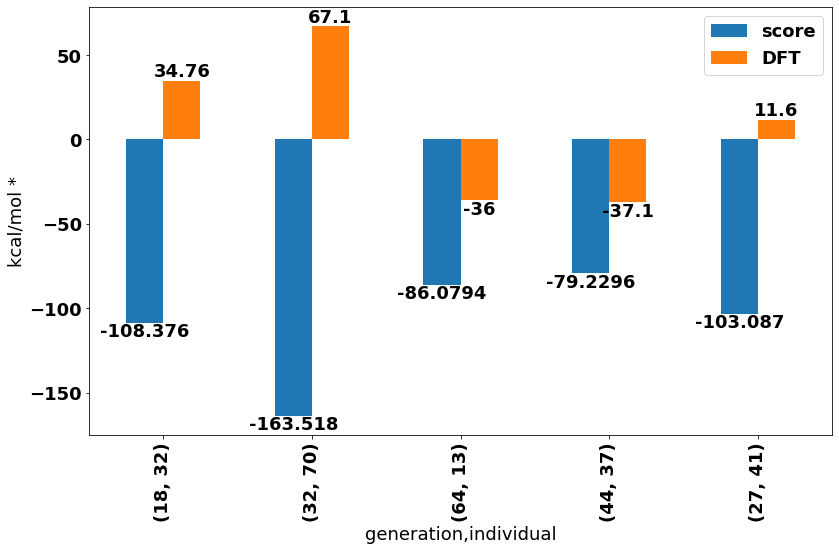

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))
df_total[['score','DFT']].plot.bar(ax=ax);
ax.set(ylabel='kcal/mol *')
for container in ax.containers:
    ax.bar_label(container)
fig.tight_layout()
fig.savefig('singlepoints.png')

In [32]:
# Show the molecules in question:
mols = [x.rdkit_mol for x in candidates]
score = [x.score for x in candidates]
list_idx = [x.idx for x in candidates]
cut_idx = [[x.cut_idx] for x in candidates]

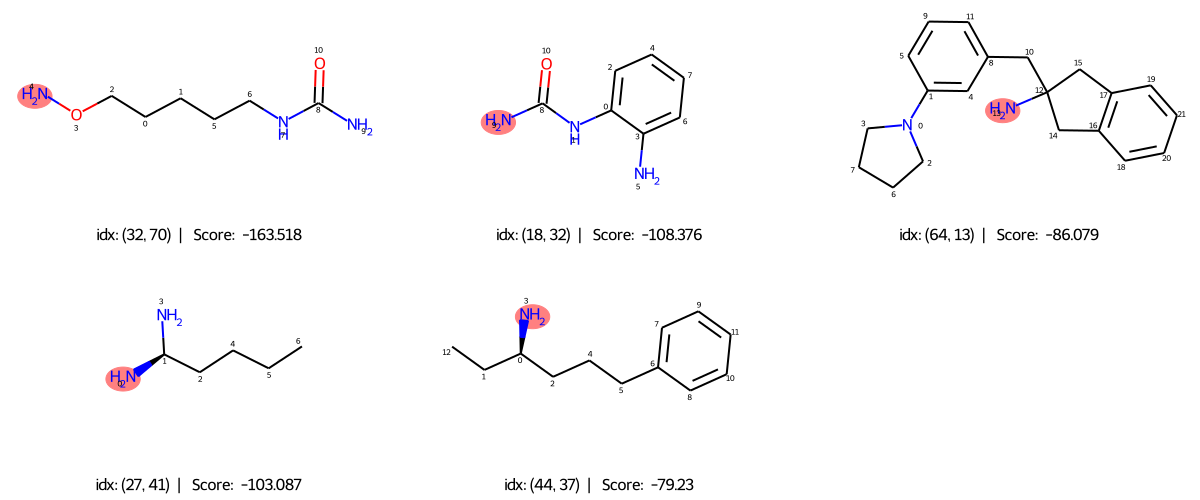

In [33]:
img  = Draw.MolsToGridImage(mols,molsPerRow=3,maxMols=25,legends=[f'idx: {x}  |   Score:  {round(score,3)}' for x, score in zip(list_idx,score)], subImgSize=(400,250), highlightAtomLists=cut_idx,returnPNG=False)
img

In [34]:
# long2
# 018_032
# 032_070
# 064_013

# longrun
# 044_037
# 027_041


In [55]:
# Results folder
res = path/'long2'

folder = '064_013'

# Candidate
candidates_path = sorted(res.rglob(f'{folder}*/*xtbopt.xyz*'))

In [56]:
candidates_path

[PosixPath('/home/magstr/generation_data/singlepoint_candidates/results/long2/064_013_Mo_N2/xtbopt.xyz'),
 PosixPath('/home/magstr/generation_data/singlepoint_candidates/results/long2/064_013_Mo_NH3/xtbopt.xyz')]

In [57]:
#a = read(candidates_path[1])
#view(a, viewer ='ngl')

In [58]:
#v=_
#v.view.add_ball_and_stick("ligand")

In [59]:
draw_generation(str(candidates_path[0]),height=400, width=600)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [60]:
# Folder for camparing structures
draw_generation(str(candidates_path[1]),height=400, width=600)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
# ~/Documents/nitrogenase/schrock/diagrams_schrock/gfn2

# High score mol (-200)

In [198]:
#-202.327 to -85.5257 after SA

In [199]:
p1='/home/magstr/generation_data/longrun/036_025_Mo_N2/conf000/xtbopt.xyz'
p2='/home/magstr/generation_data/longrun/036_025_Mo_NH3/conf001/xtbopt.xyz'

In [200]:
draw_generation(p1, height=400, width=600)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [149]:
draw_generation(p2,height=400, width=600)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol